In [1]:
import sys
!{sys.executable} -m pip install scikit-image

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

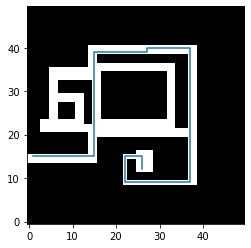

In [3]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("Maze1.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]
state_scans = env.get_state_scans(res)

In [4]:
def get_measurement_prob(state_scans, observed_scans, alpha, gamma=0.1):
    probability = 1
    for i in range(len(state_scans)):
        ri = state_scans[i]
        xi = observed_scans[i]
        exponent = np.exp( -1*( ( (xi-ri)**2) / (2*((alpha*ri)+gamma)**2) ) ) 
        fraction = 1 / ((np.sqrt(2*np.pi)) * ( (alpha*ri) + gamma))
        probability *= fraction*exponent
        
    return probability

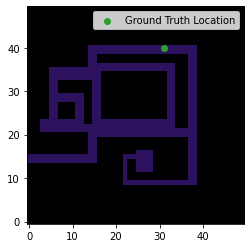

In [5]:
N = len(state_scans)
# Compute the measurement probability of the scan at each location
meas_probs = np.zeros(N)
idx = 55
for i in range(N):
    meas_probs[i] = get_measurement_prob(observed_scans[idx], state_scans[i], alpha)
# Plot the measurement probabilities on the map
env.plot_probabilities(meas_probs, p=1e-2, show_max=False)
# Plot the ground truth location from the trajectory as an green dot
plt.scatter([X[idx, 0]], X[idx, 1], c='C2') 
plt.legend(["Ground Truth Location"])

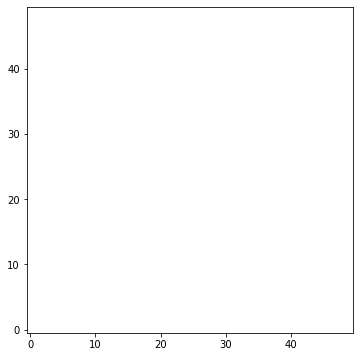

In [11]:
frames = [] # for storing the generated images
fig = plt.figure(figsize=(6, 6))
K = env.X.shape[0] # Number of states
probs = np.zeros(K)
## TODO: Setup initial probabilities, etc
f = np.ones(K)/K #K

for n in range(X.shape[0]): # T Filter every measurement that comes in   T = X.shape[0]
    ## TODO: Bayes filtering for this frame index
    
    g = np.zeros(K)
    
    for k in range(K):
        meas = get_measurement_prob(state_scans[k], observed_scans[n], alpha)
        #print(meas)
        trans = 0
    
        for j in env.neighbors[k]:
            trans = trans + f[j]/len(env.neighbors[j])
            #print(trans)
            
        g[k] = meas * trans
        
   
    
    sigma = np.sum(g)
    f = g/sigma
        
        
    plot = env.plot_probabilities(f, p=1e-2)
    plot.append(plt.scatter([X[n, 0]], [X[n, 1]], c='C0'))
    frames.append(plot)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
#ipd.HTML(ani.to_html5_video())

In [12]:
ani.save("out.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
